Using device: cuda
Loading data...


Processing rock: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


Scaler and LabelEncoder saved as 'scaler.pkl' and 'label_encoder.pkl'
Training CNN...
Epoch 1/100, Train Loss: 1.8162, Train Acc: 0.3153, Val Loss: 1.3972, Val Acc: 0.4921
Epoch 2/100, Train Loss: 1.3461, Train Acc: 0.5069, Val Loss: 1.1251, Val Acc: 0.6255
Epoch 3/100, Train Loss: 1.1476, Train Acc: 0.5955, Val Loss: 0.9942, Val Acc: 0.6649
Epoch 4/100, Train Loss: 1.0020, Train Acc: 0.6634, Val Loss: 0.8830, Val Acc: 0.7056
Epoch 5/100, Train Loss: 0.9007, Train Acc: 0.6960, Val Loss: 0.8233, Val Acc: 0.7177
Epoch 6/100, Train Loss: 0.8060, Train Acc: 0.7361, Val Loss: 0.7320, Val Acc: 0.7574
Epoch 7/100, Train Loss: 0.7238, Train Acc: 0.7599, Val Loss: 0.7041, Val Acc: 0.7711
Epoch 8/100, Train Loss: 0.6751, Train Acc: 0.7781, Val Loss: 0.6652, Val Acc: 0.7941
Epoch 9/100, Train Loss: 0.6208, Train Acc: 0.7959, Val Loss: 0.6073, Val Acc: 0.8017
Epoch 10/100, Train Loss: 0.5674, Train Acc: 0.8158, Val Loss: 0.5632, Val Acc: 0.8208
Epoch 11/100, Train Loss: 0.5141, Train Acc: 0.8306, 

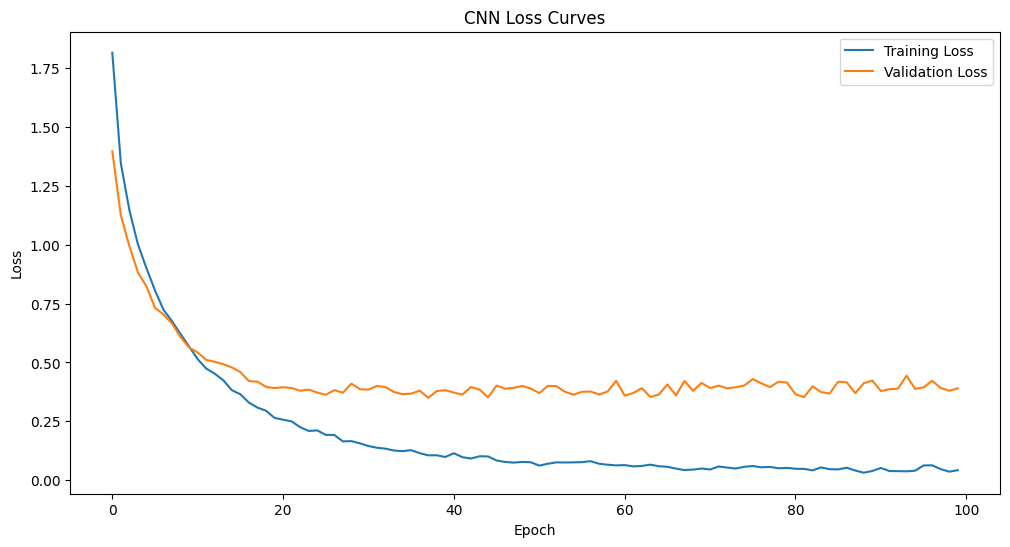

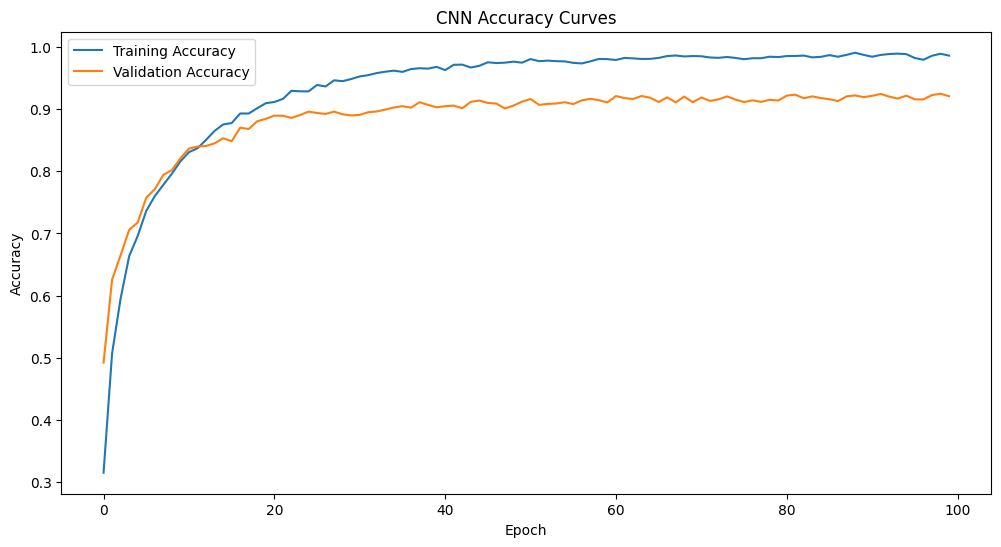

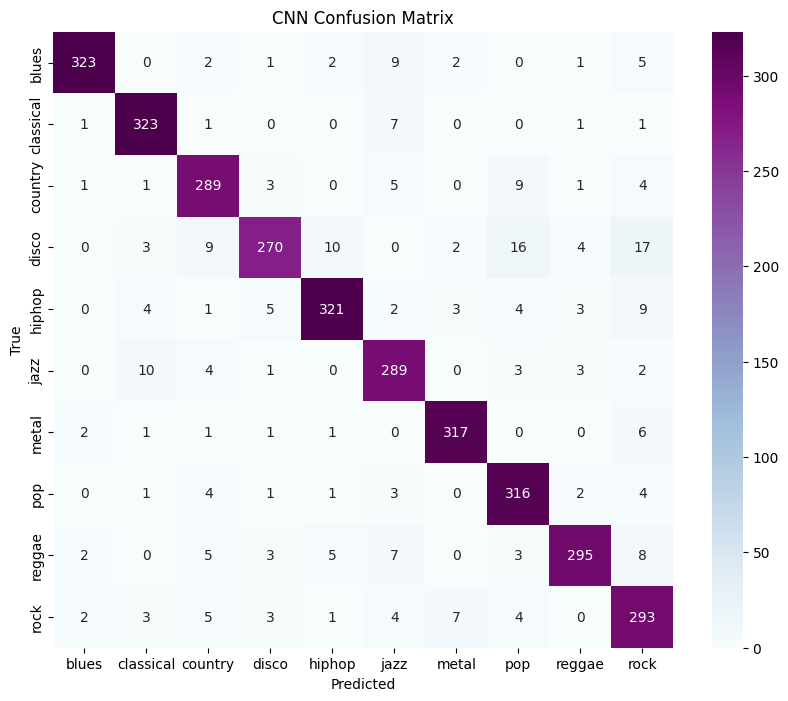

CNN training and evaluation completed. Results saved as images and displayed.


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle

# Define dataset path
DATASET_PATH = "genres/"

# Define genres (based on GTZAN dataset)
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Function to extract features from an audio file
def extract_features(file_path, segment_duration=3):
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=22050)
        # Calculate number of samples per segment
        samples_per_segment = int(segment_duration * sr)
        # Calculate number of segments
        num_segments = int(len(audio) / samples_per_segment)
        
        features = []
        for seg in range(num_segments):
            start_sample = samples_per_segment * seg
            end_sample = start_sample + samples_per_segment
            segment = audio[start_sample:end_sample]
            
            # Extract MFCCs (20 coefficients)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20).mean(axis=1)
            # Extract chroma features
            chroma = librosa.feature.chroma_stft(y=segment, sr=sr).mean(axis=1)
            # Extract spectral contrast
            contrast = librosa.feature.spectral_contrast(y=segment, sr=sr).mean(axis=1)
            # Extract spectral centroid
            centroid = librosa.feature.spectral_centroid(y=segment, sr=sr).mean()
            # Extract spectral rolloff
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr).mean()
            # Extract zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(y=segment).mean()
            
            # Combine features
            feature_vector = np.concatenate([mfcc, chroma, contrast, [centroid, rolloff, zcr]])
            features.append(feature_vector)
        
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

# Load dataset and extract features
def load_data():
    data = []
    labels = []
    
    for genre in GENRES:
        genre_path = os.path.join(DATASET_PATH, genre)
        if not os.path.exists(genre_path):
            print(f"Directory {genre_path} does not exist.")
            continue
        for file_name in tqdm(os.listdir(genre_path), desc=f"Processing {genre}"):
            if file_name.endswith('.au'):
                file_path = os.path.join(genre_path, file_name)
                features = extract_features(file_path)
                for feature in features:
                    data.append(feature)
                    labels.append(genre)
    
    return np.array(data), np.array(labels)

# Define PyTorch CNN model
class MusicGenreCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MusicGenreCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.output = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output(x)
        return x

# Training function for PyTorch model
def train_model(model, train_loader, val_loader, epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Main function
def main():
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and preprocess data
    print("Loading data...")
    X, y = load_data()
    
    if len(X) == 0:
        print("No data loaded. Exiting.")
        return
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Save scaler and label encoder for prediction
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)
    print("Scaler and LabelEncoder saved as 'scaler.pkl' and 'label_encoder.pkl'")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.33, random_state=42)
    
    # Save label encoder classes for confusion matrix
    target_names = le.classes_
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train PyTorch CNN
    print("Training CNN...")
    input_dim = X_train.shape[1]
    num_classes = len(GENRES)
    model = MusicGenreCNN(input_dim, num_classes).to(device)
    
    # Train model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, epochs=100, device=device)
    
    # Save the trained model
    torch.save(model.state_dict(), 'music_genre_cnn.pth')
    print("Model saved as 'music_genre_cnn.pth'")
    
    # Evaluate CNN
    model.eval()
    correct = 0
    total = 0
    y_pred_cnn = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred_cnn.extend(predicted.cpu().numpy())
    
    test_accuracy = correct / total
    print(f"CNN Test Accuracy: {test_accuracy*100:.2f}%")
    
    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('CNN Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('cnn_loss_curves.png')
    plt.show()  # Display in Notebook
    plt.close()
    
    # Plot accuracy curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('CNN Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('cnn_accuracy_curves.png')
    plt.show()  # Display in Notebook
    plt.close()
    
    # Confusion matrix for CNN
    conf_mat_cnn = confusion_matrix(y_test, y_pred_cnn)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat_cnn, annot=True, fmt='d', cmap='BuPu', xticklabels=target_names, yticklabels=target_names)
    plt.title('CNN Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('cnn_confusion_matrix.png')
    plt.show()  # Display in Notebook
    plt.close()
    
    print("CNN training and evaluation completed. Results saved as images and displayed.")

if __name__ == "__main__":
    main()